<a href="https://colab.research.google.com/github/vinhpeters/tf-exam/blob/main/05_transfer_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Trasnfer Learning

## Creating helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-07 21:18:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-07 21:18:26 (80.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")


--2023-04-07 21:18:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.7MB/s    in 7.9s    

2023-04-07 21:18:42 (20.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [5]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE=32
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, label_mode='categorical', batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, label_mode='categorical', batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images, labels in train_data.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.69413269e+02 1.66413269e+02 1.57413269e+02]
   [1.71903061e+02 1.68903061e+02 1.59903061e+02]
   [1.75137756e+02 1.72137756e+02 1.63137756e+02]
   ...
   [1.81933640e+02 1.87933640e+02 1.77933640e+02]
   [1.80596924e+02 1.86596924e+02 1.76596924e+02]
   [1.78872437e+02 1.84872437e+02 1.74872437e+02]]

  [[1.71571426e+02 1.68571426e+02 1.59571426e+02]
   [1.74852051e+02 1.71852051e+02 1.62852051e+02]
   [1.76198975e+02 1.73198975e+02 1.64198975e+02]
   ...
   [1.84928574e+02 1.90928574e+02 1.80928574e+02]
   [1.82857132e+02 1.88857132e+02 1.78857132e+02]
   [1.81903061e+02 1.87903061e+02 1.77903061e+02]]

  [[1.72928574e+02 1.69928574e+02 1.60928574e+02]
   [1.76198975e+02 1.73198975e+02 1.64198975e+02]
   [1.75214294e+02 1.72214294e+02 1.63214294e+02]
   ...
   [1.86785736e+02 1.92785736e+02 1.82785736e+02]
   [1.83658142e+02 1.89658142e+02 1.79658142e+02]
   [1.84433716e+02 1.90433716e+02 1.80433716e+02]]

  ...

  [[1.48923477e+02 1.41923477e+02 1.23923477e+02]
   [1

## Model 0

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE +(3,)),name='input_layer')

x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape after global average pooling 2D: {x.shape}')

outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )
history_0=model_0.fit(train_data,
                      epochs = 10,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      callbacks = [create_tensorboard_callback(dir_name='transfer_learning',experiment_name='10_perecent')])

16705208/16705208 [==============================] - 2s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_perecent/20230407-211856
Epoch 1/10
24/24 [==============================] - 19s 240ms/step - loss: 1.8573 - accuracy: 0.4120 - val_loss: 1.2947 - val_accuracy: 0.7204
Epoch 2/10
24/24 [==============================] - 5s 176ms/step - loss: 1.0884 - accuracy: 0.7653 - val_loss: 0.8810 - val_accuracy: 0.7977
Epoch 3/10
24/24 [==============================] - 5s 179ms/step - loss: 0.7889 - accuracy: 0.8213 - val_loss: 0.7070 - val_accuracy: 0.8273
Epoch 4/10
24/24 [==============================] - 5s 176ms/step - loss: 0.6466 - accuracy: 0.8520 - val_loss: 0.6059 - val_accuracy: 0.8602
Epoch 5/10
24/24 [==============================] - 4s 138ms/step - loss: 0.5460 - accuracy: 0.8693 - val_loss: 0.5715 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - 6s 206ms/step - loss: 0.4714 - accuracy:

In [10]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.4382 - accuracy: 0.8768


[0.4382472634315491, 0.876800000667572]

In [11]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [12]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


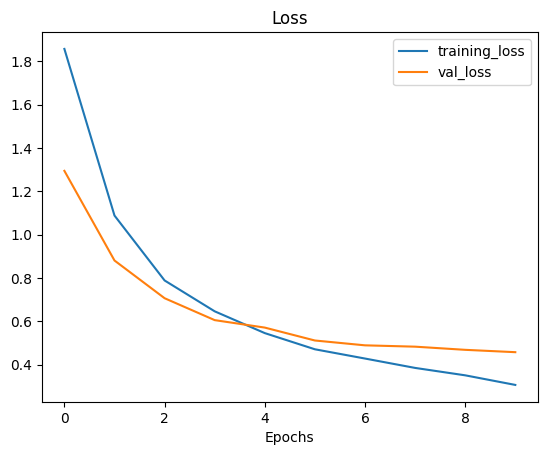

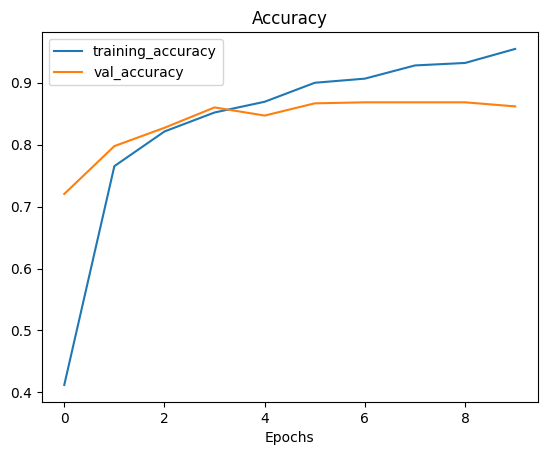

In [14]:
plot_loss_curves(history_0)

## Model 1

In [15]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2023-04-07 21:20:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  22.5MB/s    in 6.7s    

2023-04-07 21:20:24 (19.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
train_dir_1_percent = '10_food_classes_1_percent/train'

In [17]:
walk_through_dir(train_dir_1_percent)

There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.


In [18]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.


## Adding data augmentation into the model

In [19]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name='data_augmentation')

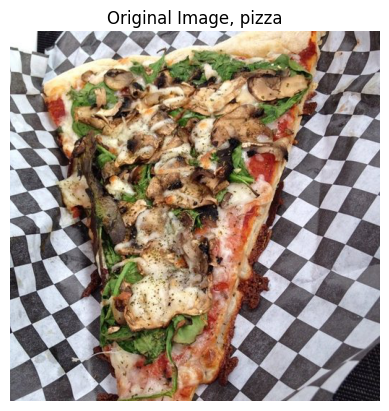

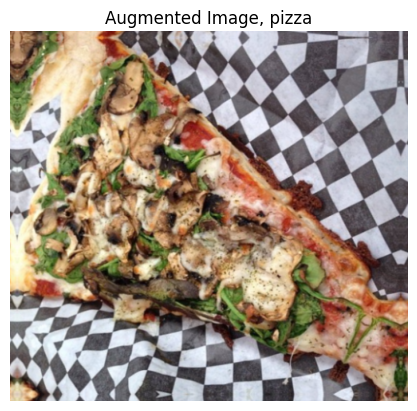

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path)

plt.imshow(img)
plt.title(f'Original Image, {target_class}')
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis=0),training=True)
plt.figure()
plt.title(f'Augmented Image, {target_class}')
plt.imshow(tf.squeeze(augmented_img)/255.);
plt.axis(False);



## Model 1 Feature Extraction

In [21]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name='input_layer')
x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)

outputs = layers.Dense(10, activation='softmax', name = 'output_layer')(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )
history_1=model_1.fit(train_data_1_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_1_percent),
                      validation_data = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      callbacks = [create_tensorboard_callback(dir_name='transfer_learning',experiment_name='1_percent_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_aug/20230407-212029
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.4194 - accuracy: 0.0857 - val_loss: 2.2538 - val_accuracy: 0.1464
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1783 - accuracy: 0.1571 - val_loss: 2.1160 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9633 - accuracy: 0.3857 - val_loss: 2.0070 - val_accuracy: 0.3438
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7822 - accuracy: 0.4286 - val_loss: 1.9000 - val_accuracy: 0.4408
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6397 - accuracy: 0.6429 - val_loss: 1.7881 - val_accuracy: 0.5362


In [22]:
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 6s 64ms/step - loss: 1.8083 - accuracy: 0.5052


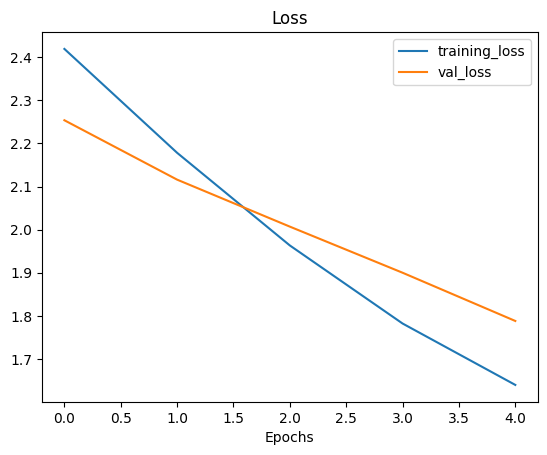

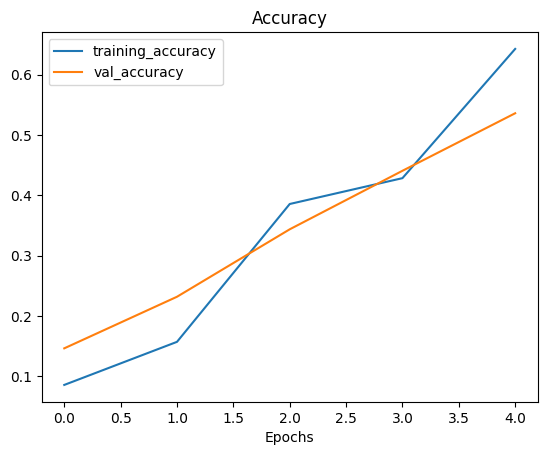

In [23]:
plot_loss_curves(history_1)

## Model 2 

In [24]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name='input_layer')
x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)

outputs = layers.Dense(10, activation='softmax', name = 'output_layer')(x)

model_2 = keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'] )


In [25]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Model Checkpoint Callback

In [26]:
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.h5'
checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq='epoch',
                                                        verbose=1)

In [27]:
initial_epochs=5
history_2=model_2.fit(train_data,
                      epochs = initial_epochs,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      callbacks = [create_tensorboard_callback(dir_name='transfer_learning',experiment_name='10_percent_aug'),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_aug/20230407-212109
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0359 - accuracy: 0.3080
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.h5
24/24 [==============================] - 23s 682ms/step - loss: 2.0359 - accuracy: 0.3080 - val_loss: 1.4734 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3144 - accuracy: 0.6787
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.h5
24/24 [==============================] - 13s 497ms/step - loss: 1.3144 - accuracy: 0.6787 - val_loss: 1.0118 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0100 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.h5
24/24 [==============================] - 12s 466ms/step - loss: 1.0100 - accuracy: 0.7560 - val_loss: 0.8126 - val_accuracy: 0.8043
Epoch 4/5
24

In [28]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.6228 - accuracy: 0.8428


[0.6227784156799316, 0.8428000211715698]

In [29]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.4382 - accuracy: 0.8768


[0.43824732303619385, 0.876800000667572]

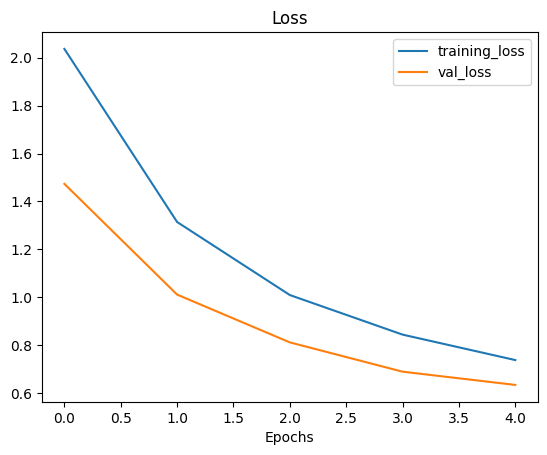

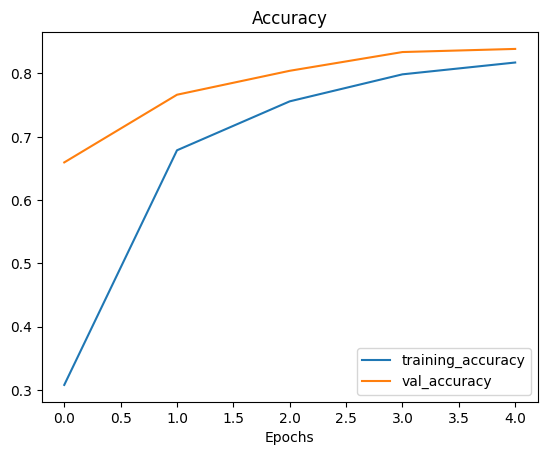

In [30]:
plot_loss_curves(history_2)

In [31]:
model_2.load_weights(checkpoint_path)

In [32]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.6228 - accuracy: 0.8428


## Model 3

In [33]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb87cb73130> True
<keras.engine.sequential.Sequential object at 0x7fb890276f10> True
<keras.engine.functional.Functional object at 0x7fb87cbb6ac0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fb87cb9fee0> True
<keras.layers.core.dense.Dense object at 0x7fb87c83dc40> True


In [34]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [35]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'] )

In [36]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [37]:
fine_tune_epochs = initial_epochs + 5

history_fine_10 = model_2.fit(train_data, 
                      epochs = fine_tune_epochs,
                      steps_per_epoch = len(train_data),
                      validation_data = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      initial_epoch= history_2.epoch[-1],
                      callbacks = [create_tensorboard_callback(dir_name='transfer_learning',experiment_name='10_percent_fine_tuning')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuning/20230407-212303
Epoch 5/10
24/24 [==============================] - 24s 553ms/step - loss: 0.6337 - accuracy: 0.8107 - val_loss: 0.5261 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 11s 458ms/step - loss: 0.4878 - accuracy: 0.8693 - val_loss: 0.4687 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 11s 439ms/step - loss: 0.4359 - accuracy: 0.8760 - val_loss: 0.4584 - val_accuracy: 0.8405
Epoch 8/10
24/24 [==============================] - 11s 454ms/step - loss: 0.3998 - accuracy: 0.8733 - val_loss: 0.4404 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 10s 395ms/step - loss: 0.3202 - accuracy: 0.9147 - val_loss: 0.4207 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 9s 346ms/step - loss: 0.2954 - accuracy: 0.9160 - val_loss: 0.4303 - val_accuracy: 0.8487


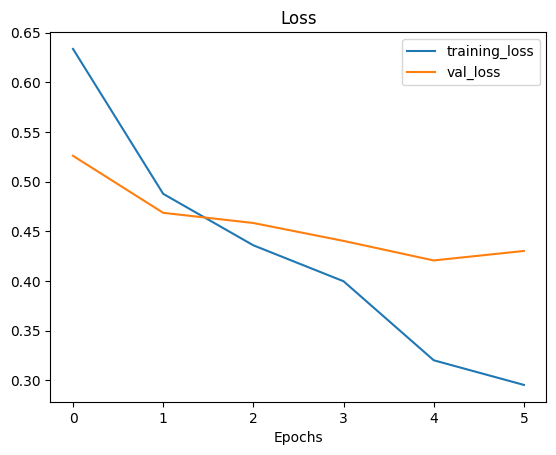

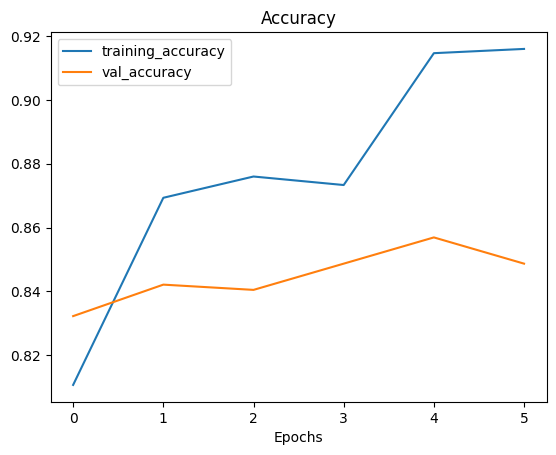

In [38]:
plot_loss_curves(history_fine_10)

In [39]:
def compare_historys(original_history, new_history, initial_epochs = 5 ):
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label='Training Accuracy')
  plt.plot(total_val_acc,label='Val Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(),label='Fine Tuning Start')
  plt.legend()
  plt.title('Training and Validation Accuracy')

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label='Training Loss')
  plt.plot(total_val_loss,label='Val Loss')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(),label='Fine Tuning Start')
  plt.legend()
  plt.title('Training and Validation Loss')

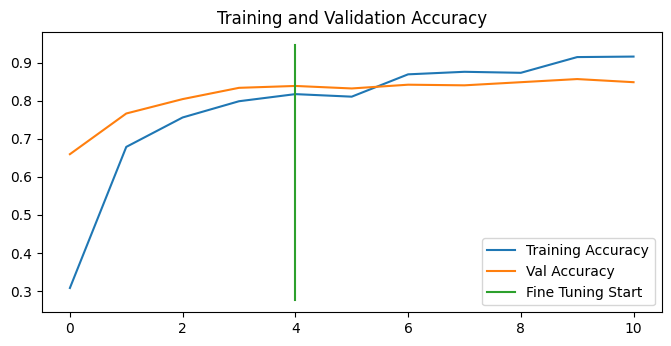

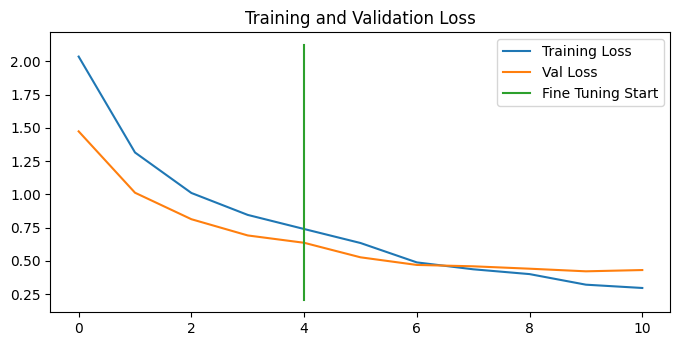

In [40]:
compare_historys(history_2, history_fine_10, initial_epochs = 5) 

In [41]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.4196 - accuracy: 0.8536


[0.419630229473114, 0.853600025177002]

## Model 4

In [42]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-04-07 21:24:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 64.233.170.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.9MB/s    in 22s     

2023-04-07 21:24:54 (22.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [43]:
unzip_data('/content/10_food_classes_all_data.zip')

In [44]:
train_dir_all = '10_food_classes_all_data/train'
train_dir_ = '10_food_classes_all_data/test'

train_data_all = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all, image_size=IMG_SIZE, label_mode='categorical', batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, label_mode='categorical', batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [58]:
model_2.layers[2].trainable = False

In [46]:
model_2.load_weights(checkpoint_path)

In [47]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.6228 - accuracy: 0.8428


[0.6227782964706421, 0.8428000211715698]

In [59]:
for layer in base_model.layers[-10:]:
  layer.trainable = True

In [60]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [61]:
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'] )

In [62]:
fine_tune_epochs = initial_epochs + 5

history_all_data = model_2.fit(train_data_all, 
                      epochs = fine_tune_epochs,
                      steps_per_epoch = len(train_data_all),
                      validation_data = test_data,
                      validation_steps = int(0.25 * len(test_data)),
                      initial_epoch= history_2.epoch[-1],
                      callbacks = [create_tensorboard_callback(dir_name='transfer_learning',experiment_name='all_data_fine_tuning')])

Saving TensorBoard log files to: transfer_learning/all_data_fine_tuning/20230407-213434
Epoch 5/10
235/235 [==============================] - 75s 284ms/step - loss: 0.8141 - accuracy: 0.7733 - val_loss: 0.5362 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 56s 235ms/step - loss: 0.7589 - accuracy: 0.7831 - val_loss: 0.4977 - val_accuracy: 0.8618
Epoch 7/10
235/235 [==============================] - 50s 208ms/step - loss: 0.7172 - accuracy: 0.7944 - val_loss: 0.4551 - val_accuracy: 0.8717
Epoch 8/10
235/235 [==============================] - 48s 200ms/step - loss: 0.6822 - accuracy: 0.7987 - val_loss: 0.4620 - val_accuracy: 0.8684
Epoch 9/10
235/235 [==============================] - 46s 193ms/step - loss: 0.6626 - accuracy: 0.7973 - val_loss: 0.4354 - val_accuracy: 0.8618
Epoch 10/10
235/235 [==============================] - 43s 181ms/step - loss: 0.6447 - accuracy: 0.8041 - val_loss: 0.4060 - val_accuracy: 0.8816


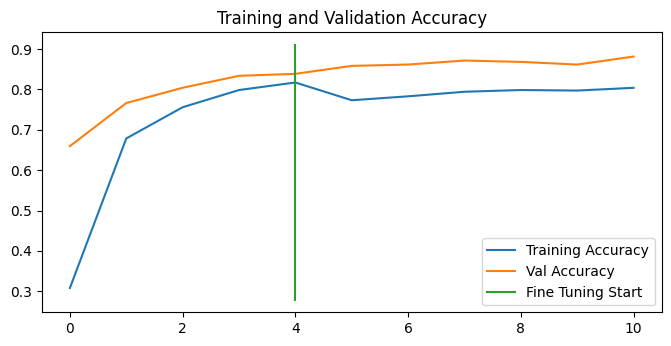

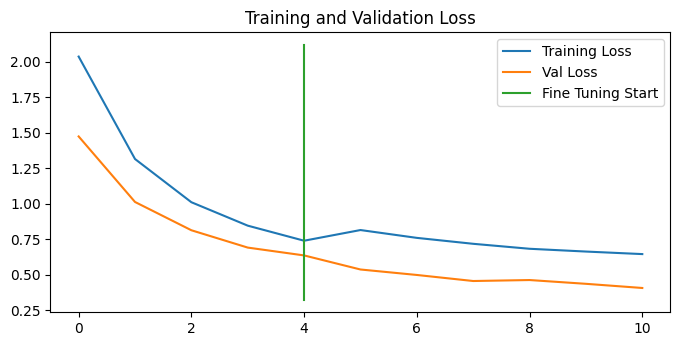

In [63]:
compare_historys(history_2, history_all_data, initial_epochs = 5) 

## Compare models with tensorboard

In [72]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name 'Transfer Learning Experiments with 10 Food 101 Classes' \
  --description 'Fine tuning with varying amounts of data with EfficentNetB0' \
  --one_shot


2023-04-07 21:50:18.407156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/kVZFbGJ1SgOx5ba9vooQxQ/

[2023-04-07T21:50:20] Started scanning logdir.
[2023-04-07T21:50:30] Total uploaded: 192 scalars, 0 tensors, 5 binary objects (4.3 MB)
[2023-04-07T21:50:30] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/kVZFbGJ1SgOx5ba9vooQxQ/
